<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/11_virtual_screening/1_Predict_ability_inhibition_ERK2_preparing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Preparing dataset 

**Problem:** Predict the ability of molecules to inhibit a protein known as ERK2 (Mitogen Activated Protein Kinase 1, MAPK1).

ERK2 plays an important role in the signaling pathways that regulate how cells multiply. ERK2 has been implicated in a number of cancers. It's important to know some inhibitors for some types of cancer.

**Solution:** We will train the model to distinguish a set of ERK2 active compounds from a set of decoy compounds.

*What is decoy compounds?*

Decoys are molecules that are presumed to be inactive against a target (i.e. will not likely bind to the target) and are used to validate the performance of molecular docking or a virtual screening workflow.

**Database:**The active and decoy compounds are derived from the [DUD-E database](http://dud.docking.org/).

- A total of 2,950 active compounds against a total of 40 targets
- For each active, 36 "decoys" with similar physical properties (e.g. molecular weight, calculated LogP) but dissimilar topology.

## Setup

In [1]:
!pip install rdkit-pypi

     |████████████████████████████████| 18.6 MB 1.8 MB/s 


## Dataset

### Exploring the dataset

In [2]:
import os
import requests

from rdkit import Chem # For chemistry functions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit.Chem import PandasTools
import pandas as pd
import seaborn as sns # Making graphs

#### Active molecules

In [3]:
# Getting active molecules (SMILES strings format)
url = 'https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/actives_final.ism'
answer = requests.get(url)

In [4]:
!mkdir mk01

In [5]:
# save file
filepath_actives = os.path.join('mk01', 'actives_final.ism')
with open(filepath_actives, 'w') as f:
  f.write(answer.text)

In [6]:
# Create Pandas dataframe
active_df = pd.read_csv(filepath_actives, header=None, sep=" ")
active_rows, active_cols = active_df.shape
active_df.columns = ['SMILES', 'ID', 'ChEMBL_ID']
active_df['label'] = ['Active'] * active_rows
PandasTools.AddMoleculeColumnToFrame(frame=active_df, smilesCol='SMILES', molCol='Mol')

In [7]:
def add_property_columns_to_df(df_in):
  """Add the calculated properties (mw, logP and charge) to a dataframe
  """
  # Molecular weight
  df_in['mw'] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
  # The ability to partition from an oily substance (octanol) to water.
  df_in['logP'] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
  # Charge, is it positive or negative?
  df_in['charge'] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,,487.991,5.12922,0

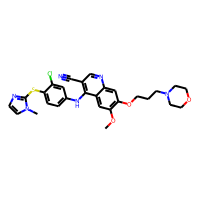
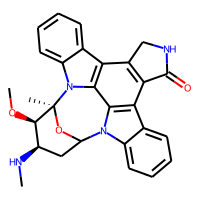
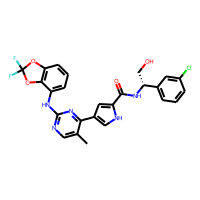
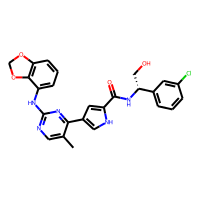
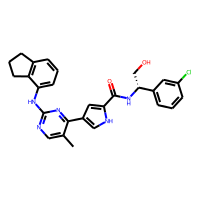

In [8]:
# add the calculated properties
add_property_columns_to_df(active_df)
active_df.head()

#### Decoy molecules

In [9]:
# Getting the decoy molecules (SMILES strings format)
url = 'https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/decoys_final.ism'
answer = requests.get(url)

filepath_decoys = os.path.join('mk01', 'decoys_final.ism')
with open(filepath_decoys, 'w') as f:
  f.write(answer.text)

decoy_df = pd.read_csv(filepath_decoys, header=None, sep=" ")
decoy_rows, decoy_cols = decoy_df.shape
decoy_df.columns = ['SMILES', 'ID']
decoy_df['label'] = ['Decoy'] * decoy_rows
PandasTools.AddMoleculeColumnToFrame(frame=decoy_df, smilesCol='SMILES', molCol='Mol')

,SMILES,ID,label,Mol,mw,logP,charge
0,C1COCCNC(=S)NCCOCCNC(=S)N1,C03897368,Decoy,,292.430,-1.03860,0
1,c1cc(ccc1[C@H]2c3ccc(cc3OC(=C2C#N)N)N)O,C00242247,Decoy,,279.299,2.19258,0
2,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2C(=O)C[...,C04096778,Decoy,,366.498,1.65330,0
3,Cc1ccc2c(c1)cc(c(=O)[nH]2)[C@@H]3c4c(n[nH]c4OC...,C00421469,Decoy,,333.351,2.08622,0
4,Cc1cc2cc(c(=O)[nH]c2cc1C)[C@@H]3c4c(n[nH]c4OC(...,C00421479,Decoy,,347.378,2.39464,0

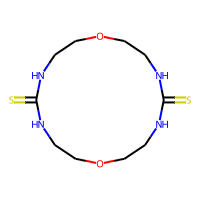
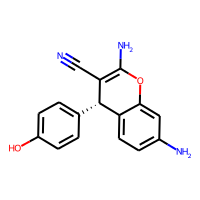
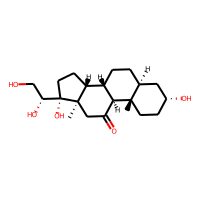
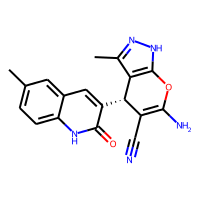
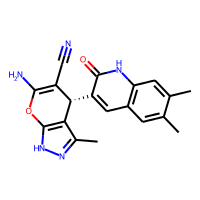

In [10]:
# add the calculated properties
add_property_columns_to_df(decoy_df)
decoy_df.head()

#### Comparing properties of the actives and decoy molecules

In [11]:
# Creating a single dataframe with the decoy and active molecules
tmp_df = active_df.append(decoy_df)

To do the comparison, we will use violin plots (it provides a mirrored, horizontal view of a frequency distribution).

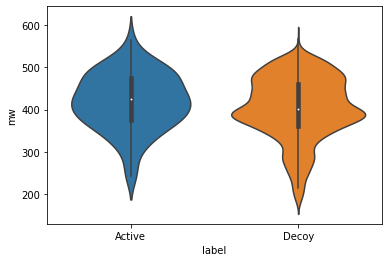

In [12]:
""" An examination of these plots shows that the molecular weight distributions
for the two sets are roughly equivalent.
"""
sns.violinplot(x=tmp_df['label'], y=tmp_df['mw'])

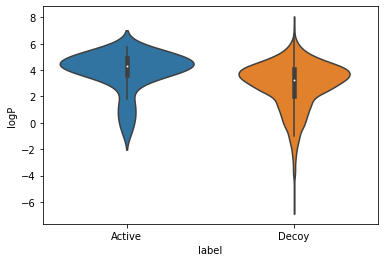

In [13]:
""" LogP distribution, logP is the ability to partition from an oily substance 
(octanol) to water.
""" 
sns.violinplot(x=tmp_df['label'], y=tmp_df['logP'])

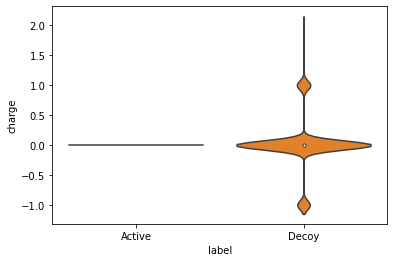

In [14]:
""" Charge distributions
""" 
sns.violinplot(x=tmp_df['label'], y=tmp_df['charge'])

We can see a significant difference, this appears to be because the active and decoy sets were not prepared in a consistent fashion.

We can address this problem by modifying the chemical structures of the decoy molecules to neutralize their charges.

In [15]:
# Getting code file that contains NeutraliseCharges() function.
url = 'https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/neutralize.py'
answer = requests.get(url)

with open('neutralize.py', 'w') as f:
  f.write(answer.text)

In [16]:
from neutralize import NeutraliseCharges

In [17]:
# Neutralize charges of the decoy molecules 
revised_decoy_df = decoy_df[['SMILES', 'ID', 'label']].copy()

revised_decoy_df['SMILES'] = [NeutraliseCharges(x)[0] for x in revised_decoy_df['SMILES']]

,SMILES,ID,label,Mol,mw,logP,charge
0,C1COCCNC(=S)NCCOCCNC(=S)N1,C03897368,Decoy,,292.430,-1.03860,0
1,c1cc(ccc1[C@H]2c3ccc(cc3OC(=C2C#N)N)N)O,C00242247,Decoy,,279.299,2.19258,0
2,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2C(=O)C[...,C04096778,Decoy,,366.498,1.65330,0
3,Cc1ccc2c(c1)cc(c(=O)[nH]2)[C@@H]3c4c(n[nH]c4OC...,C00421469,Decoy,,333.351,2.08622,0
4,Cc1cc2cc(c(=O)[nH]c2cc1C)[C@@H]3c4c(n[nH]c4OC(...,C00421479,Decoy,,347.378,2.39464,0

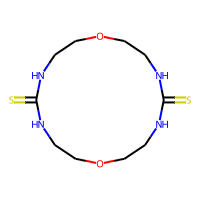
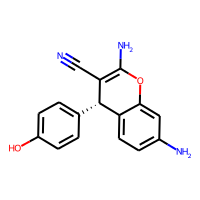
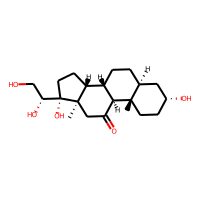
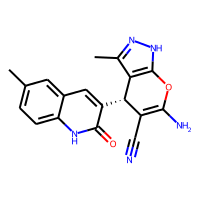
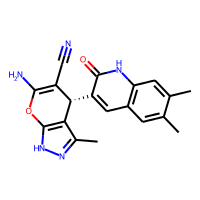

In [18]:
# Add the molecule columnd to the new dataframe
PandasTools.AddMoleculeColumnToFrame(
  frame=revised_decoy_df, 
  smilesCol='SMILES', 
  molCol='Mol'
)

# calculate properties
add_property_columns_to_df(revised_decoy_df)
revised_decoy_df.head()

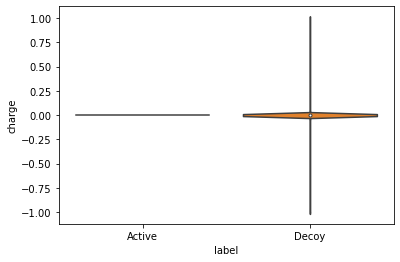

In [19]:
""" Compare the charge distributions (again) of the active molecules with those 
of our neutralized decoys.
"""
new_tmp_df = active_df.append(revised_decoy_df)
sns.violinplot(x=new_tmp_df['label'], y=new_tmp_df['charge'])

We have reduced the fraction of charged decoy molecules from 16% to 0.3%. We can now be confident that our active and decoy sets are reasonably well balanced.

### Preparing dataset


In [20]:
active_df['is_active'] = [1] * active_df.shape[0] # active molecules
revised_decoy_df['is_active'] = [0] * revised_decoy_df.shape[0] # decoy molecules
combined_df = active_df.append(revised_decoy_df)[['SMILES', 'ID', 'is_active']]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [23]:
combined_df.sample(n=6)

,SMILES,ID,is_active
3087,c1ccc2c(c1)c(c[nH]2)CCNC(=O)C[C@H]3CS[C@@H](N3...,C39707794,0
48,Cn1c-2c(c(n1)C(=O)N)CCc3c2nc(nc3)NC4CCN(CC4)C(...,603518,1
43,Cc1c2ccc(cc2oc(=O)c1Cc3ccc(cc3)F)OC(=O)N(C)C,127465,1
821,CN(Cc1ccccc1)c2c(c(ncn2)Nc3ccc(cn3)Br)N,C40662380,0
841,COc1ccc(c(c1)[C@H](CNC(=O)NC23CC4CC(C2)CC(C4)C...,C61964134,0
4506,CCOc1ccc(cc1)NC(=O)c2c3c(sc2/N=C/c4ccc(cc4)N(C...,C09907631,0


In [24]:
# save data as a CSV file, we are going to use it in the notebook 2
filename = 'dude_erk1_mk01.csv'
combined_df.to_csv(filename, index=False)

from google.colab import files

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>